In [1]:
# 这个文件主要是用来尝试实现加入角度响应后的处理函数


数据类型： float64
数组形状： (472, 750)
数据范围： 0.0 ~ 5.0


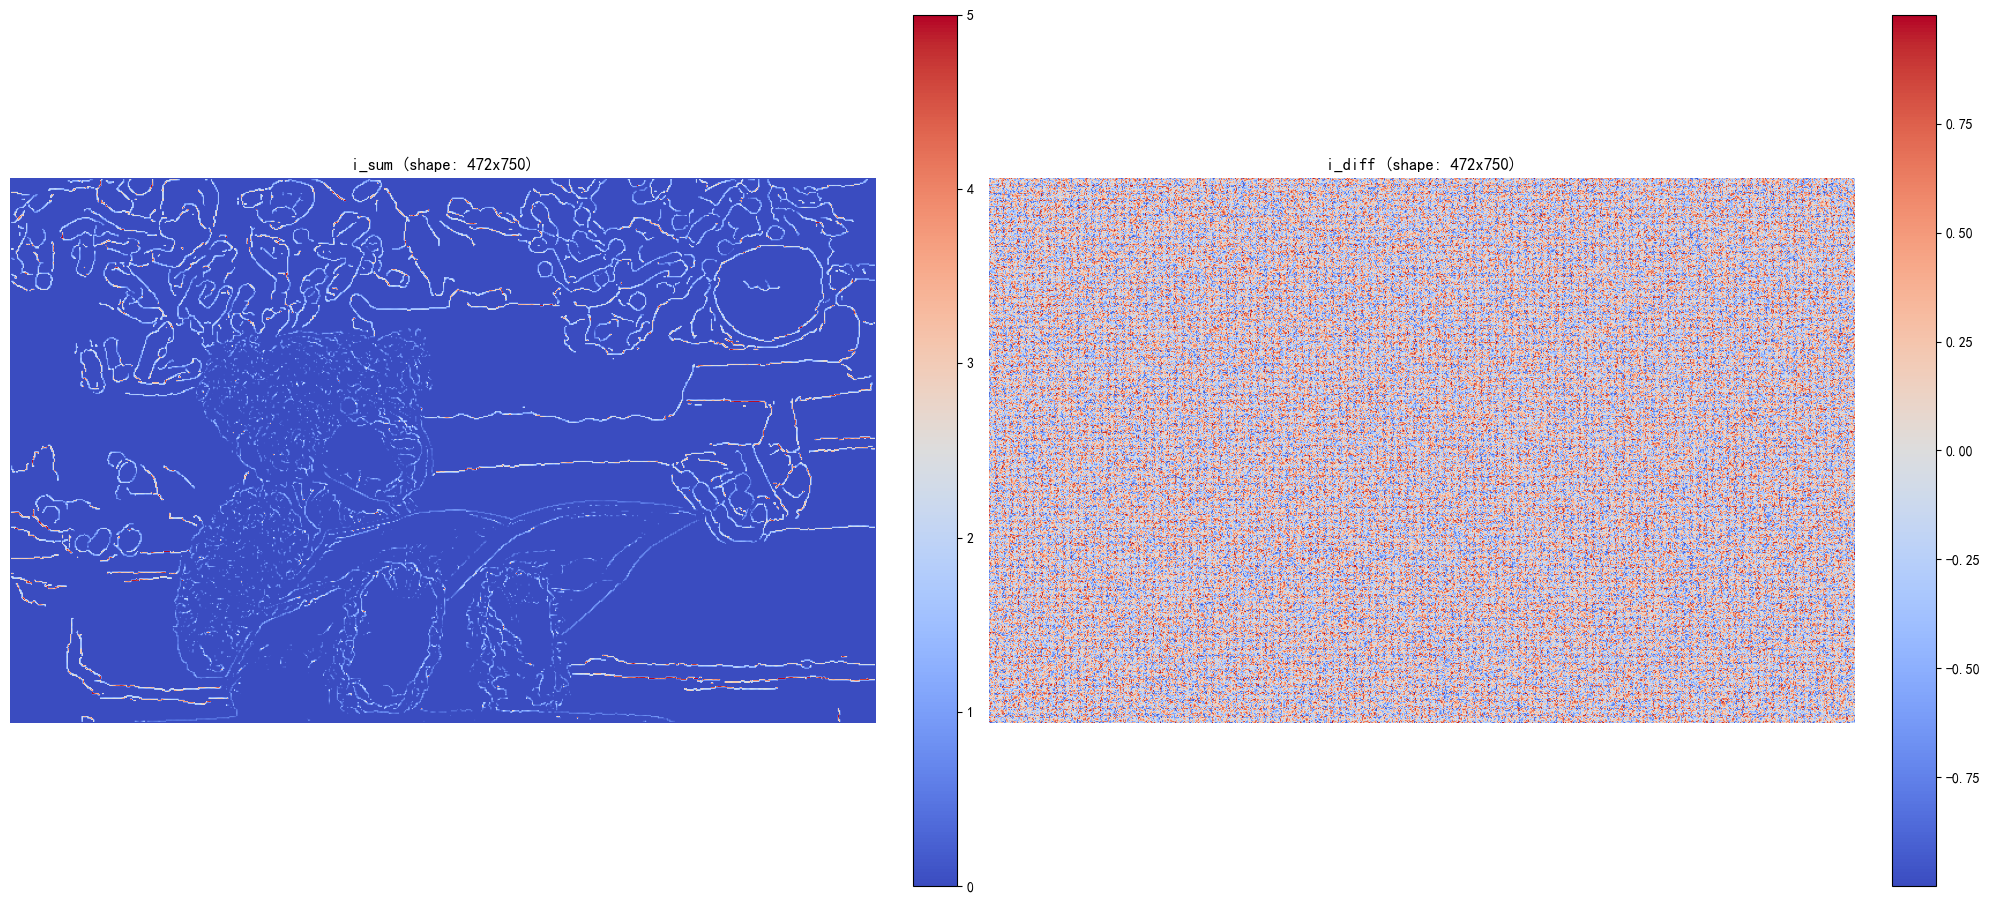

In [80]:
# angle_mask
# input: i_diff,i_sum
# output: angle_mask

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 加载数据
i_sum = np.load('input0.png_sparse_bmap.npy')
h,w = i_sum.shape
i_diff = np.random.uniform(-1, 1, (h,w))
# 查看数据信息（可选）
print("数据类型：", i_sum.dtype)  # 查看数组的数据类型（如 uint8、float32 等）
print("数组形状：", i_sum.shape)  # 查看数组的维度（如 (H, W) 或 (H, W, C)）
print("数据范围：", i_sum.min(), "~", i_sum.max())  # 查看数值范围

# 子图1：显示数组的热图（冷色到暖色）
plt.figure(figsize=(20, 10))
plt.subplot(121)
im = plt.imshow(i_sum, cmap='coolwarm')  # 'coolwarm' 冷色（低值）到暖色（高值）
plt.title(f'i_sum (shape: {h}x{w})')
plt.axis('off')  # 隐藏坐标轴
plt.colorbar(im, fraction=0.046, pad=0.04)  # 添加颜色条

# 子图2：显示形状信息（可选，用文本标注）
plt.subplot(122)
im = plt.imshow(i_diff, cmap='coolwarm')  # 'coolwarm' 冷色（低值）到暖色（高值）
plt.title(f'i_diff (shape: {h}x{w})')
plt.axis('off')  # 隐藏坐标轴
plt.colorbar(im, fraction=0.046, pad=0.04)  # 添加颜色条

plt.tight_layout()  # 调整布局
plt.show()

def show_cool_warm_photo(data, cmap='coolwarm',title=None,threshold = None,if_show=False):
    '''
    : param data: 图片数据
    : param cmap: 颜色映射
    : param title: 图片标题
    : param range: 显示的数据范围
    '''
    if threshold is not None:
        data = np.where((data <= threshold[1]) & (data >= threshold[0]), data,0)  # 去除超过threshold的
    im = plt.imshow(data, cmap=cmap)
    if title is not None:
        plt.title(title)
    plt.axis('off')  # 隐藏坐标轴
    plt.colorbar(im,fraction=0.046, pad=0.04)  # 添加颜色条
    if if_show:
        plt.show()


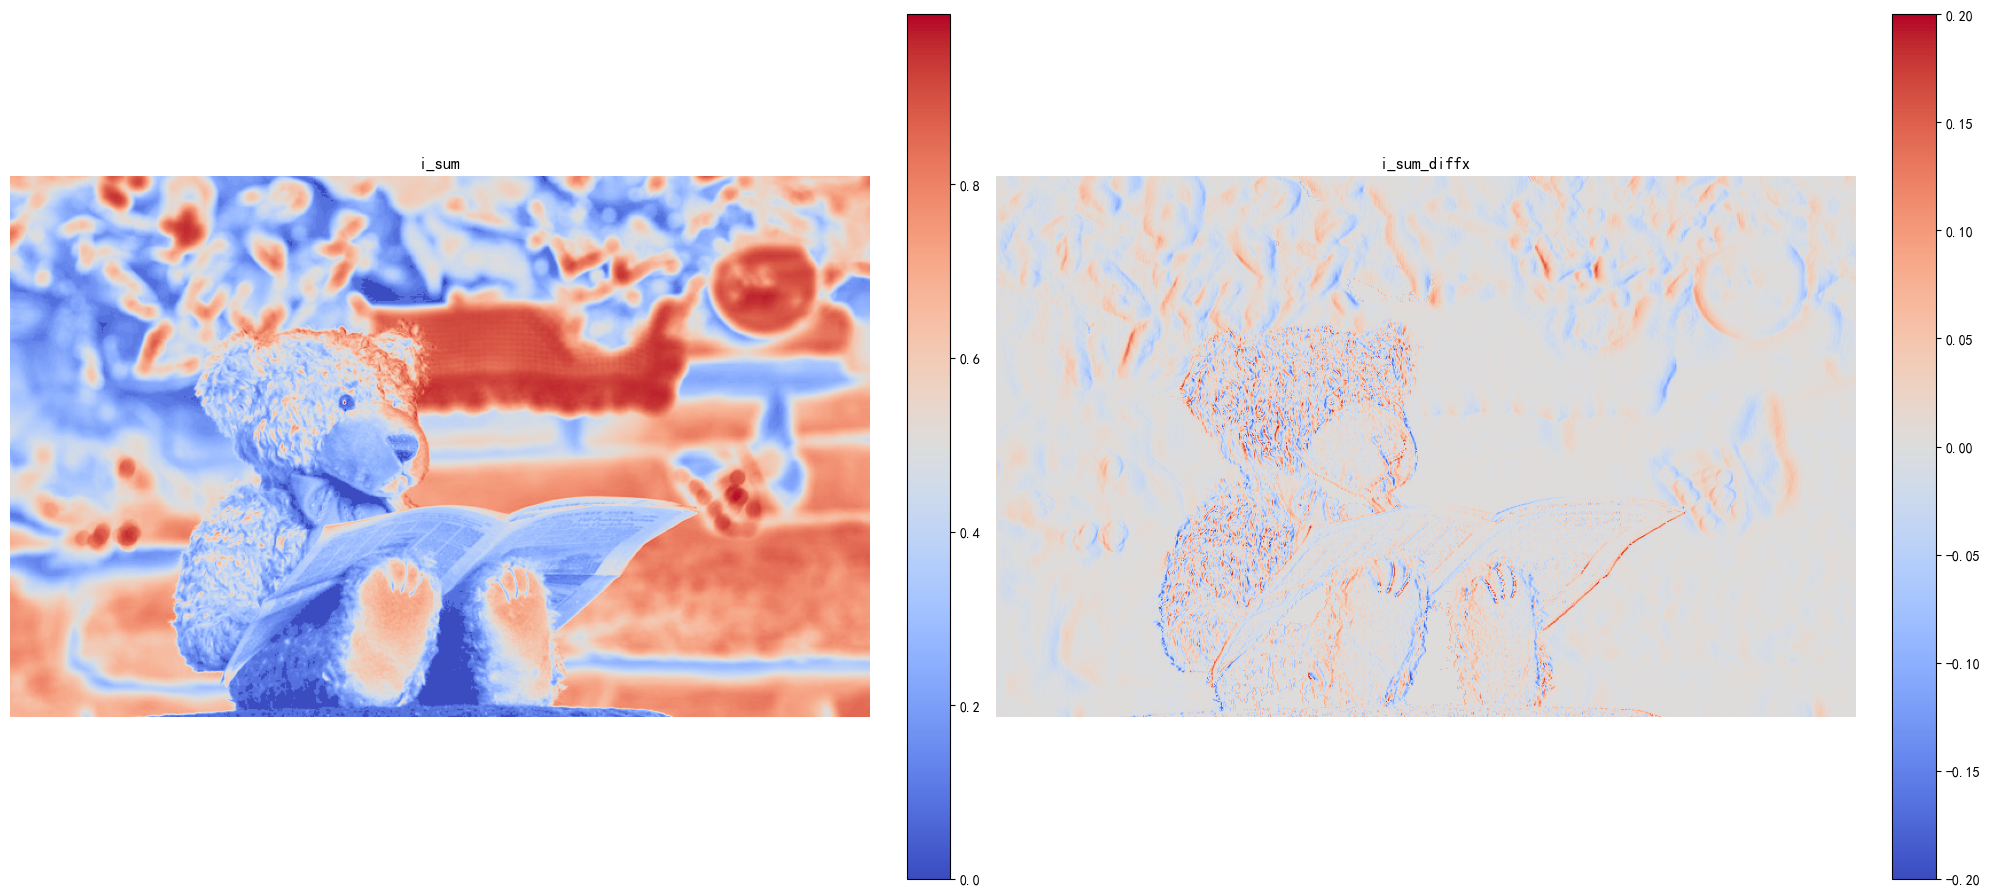

[-1. -0.  1.]


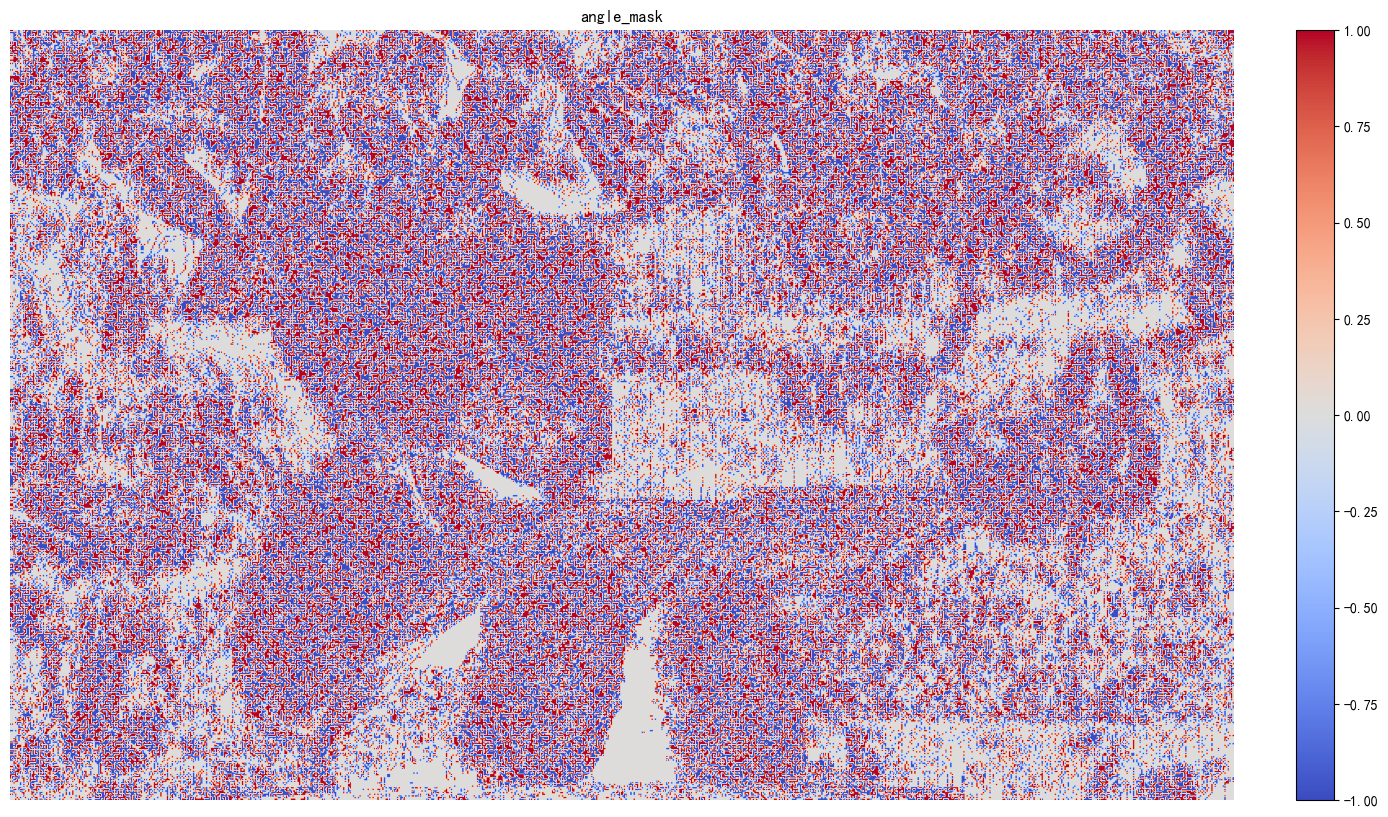

In [89]:
# 几种常见的差分算子
# 参考代码链接：https://blog.csdn.net/2401_83189603/article/details/149646314
import numpy as np
import matplotlib.pyplot as plt
import cv2
i_sum = cv2.imread("input0.png",cv2.IMREAD_GRAYSCALE)/255
h,w = i_sum.shape
i_diff = np.random.uniform(-1, 1, (h,w))


# 计算x方向差分
kernel=np.array([[0,0,0],
                 [-1,1,0],
                 [0,0,0]],dtype=np.float32)
# 二维卷积操作
i_sum_diffx=cv2.filter2D(i_sum,-1,kernel)

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
show_cool_warm_photo(i_sum,title = "i_sum")
plt.subplot(1,2,2)
show_cool_warm_photo(i_sum_diffx,title = "i_sum_diffx",threshold=(-0.2,0.2))
plt.tight_layout()  # 调整布局
plt.show()



# 计算angle_mask
# input: i_diff,i_sum,threshold
# output: angle_mask
threshold = 0.5
sign_diff = np.sign(i_diff)
sign_sum_x_diff = np.sign(i_sum_diffx)
angle_mask = sign_diff * sign_sum_x_diff
angle_mask = np.where(abs(sign_diff)>threshold,angle_mask,0)
print(np.unique(angle_mask))
plt.figure(figsize=(20,10))
show_cool_warm_photo(angle_mask,title = "angle_mask",threshold=(-2,2))
plt.show()



def generate_angle_mask(i_diff,i_sum,threshold = 0.1,kernel = None):
    '''
    :param i_diff: diff图像
    :param i_sum: 低通图
    :param threshold: 阈值
    :return: angle_mask 焦前焦后mask
    '''

    # 计算x方向差分
    if kernel is None:
        kernel=np.array([[0,0,0],
                        [-1,1,0],
                        [0,0,0]],dtype=np.float32)
    # 二维卷积操作
    i_sum_diffx=cv2.filter2D(i_sum,-1,kernel)
    sign_diff = np.sign(i_diff)
    sign_sum_x_diff = np.sign(i_sum_diffx)
    angle_mask = sign_diff * sign_sum_x_diff
    angle_mask = np.where(abs(sign_diff)>threshold,angle_mask,0)
    return angle_mask


# angle_mask = generate_angle_mask(i_diff,i_sum,threshold = 0.1)
# plt.figure(figsize=(20,10))
# show_cool_warm_photo(angle_mask,title = "angle_mask",threshold=(-2,2))
# plt.show()

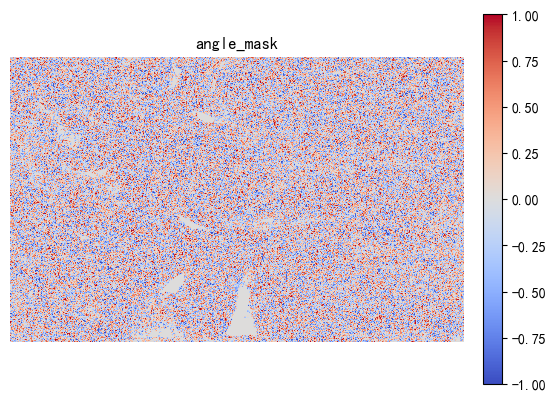

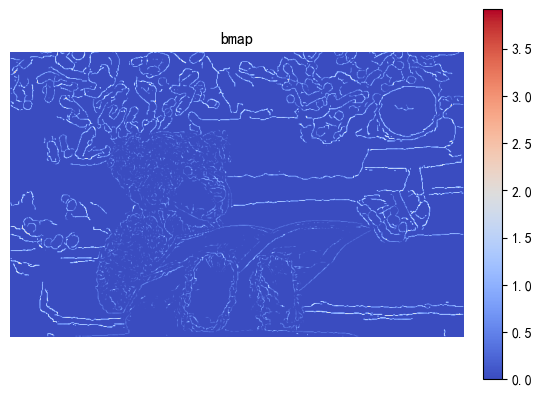

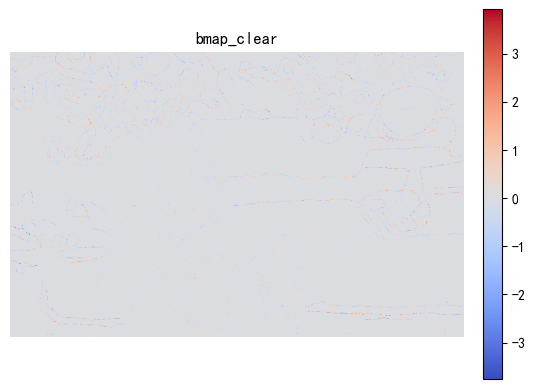

In [103]:
# 基于angle_mask去除bmap的模糊性
import numpy as np
import matplotlib.pyplot as plt
import cv2
i_sum = cv2.imread("input0.png",cv2.IMREAD_GRAYSCALE)/255
h,w = i_sum.shape
i_diff = np.random.uniform(-1, 1, (h,w))
kernel=np.array([[-1,-1,0],
                 [-1,3,0],
                 [0,0,0]],dtype=np.float32)
angle_mask = generate_angle_mask(i_diff,i_sum,kernel =kernel)
show_cool_warm_photo(angle_mask,title = "angle_mask",if_show=True)

bmap = np.load("input0.png_filtered_bmap.npy")
show_cool_warm_photo(bmap,title = "bmap",if_show=True)
bmap_clear = bmap*angle_mask

show_cool_warm_photo(bmap_clear,title = "bmap_clear",if_show=True)

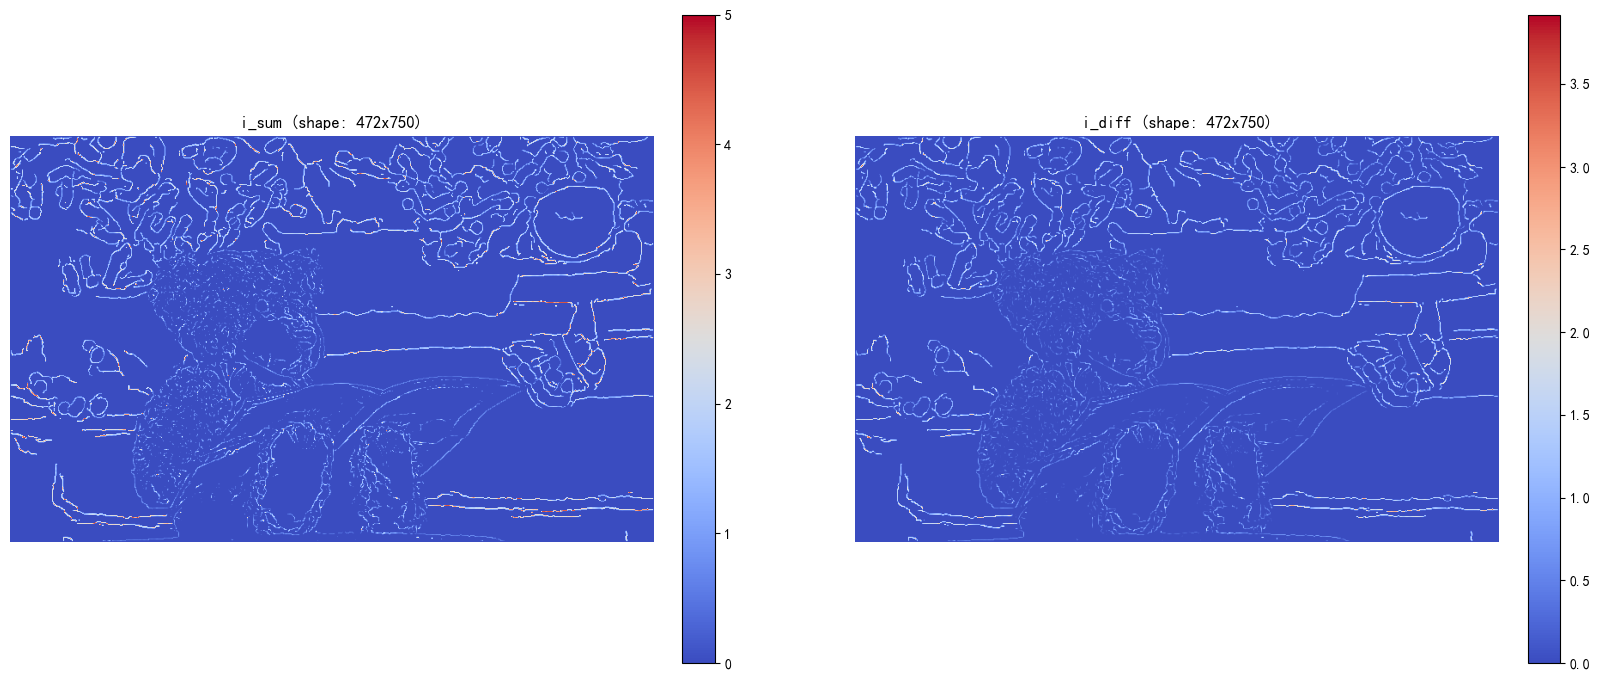

In [9]:
i_sum = np.load("input0.png_sparse_bmap.npy")
i_diff = np.load("input0.png_filtered_bmap.npy")
plt.figure(figsize=(20, 10))
plt.subplot(121)
im = plt.imshow(i_sum, cmap='coolwarm')  # 'coolwarm' 冷色（低值）到暖色（高值）
plt.title(f'i_sum (shape: {h}x{w})')
plt.axis('off')  # 隐藏坐标轴
plt.colorbar(im, fraction=0.046, pad=0.04)  # 添加颜色条

# 子图2：显示形状信息（可选，用文本标注）
plt.subplot(122)
im = plt.imshow(i_diff, cmap='coolwarm')  # 'coolwarm' 冷色（低值）到暖色（高值）
plt.title(f'i_diff (shape: {h}x{w})')
plt.axis('off')  # 隐藏坐标轴
plt.colorbar(im, fraction=0.046, pad=0.04)  # 添加颜色条